# pyRadiomics feature visualization using multi-dimensional scaling and heatmaps

pyRadiomics features can be used to classify and group images.  Three techniques will be demonstrated, multi-dimensional scaling for visual grouping of datasets, heatmaps to show correlations between features, and a clustermap to show hierarchial clustering of features.

For more detailed examples and links to source code, visit http://radiomics.io

In this example, we will download and process data provided by [Brigham and Women's Surgical Planning Lab](https://www.spl.harvard.edu/).  The data has kindly been made available by the SPL to support reproducible science.

> Kaus M.R., Warfield S.K., Nabavi A., Black P.M., Jolesz F.A., Kikinis R. Automated Segmentation of Brain Tumors. SPL 2007 Dec http://www.spl.harvard.edu/publications/item/view/1180

> Michael Kaus, Simon K. Warfield, Arya Nabavi, Peter M. Black, Ferenc A. Jolesz, and Ron Kikinis. Automated Segmentation of MRI of Brain Tumors.
Radiology. 2001 Feb;218(2):586-91. http://www.spl.harvard.edu/publications/item/view/169

> Simon K. Warfield, Michael Kaus, Ferenc A. Jolesz, and Ron Kikinis. Adaptive, Template Moderated, Spatially Varying Statistical Classification. Med Image Anal. 2000 Mar;4(1):43-55. http://www.spl.harvard.edu/publications/item/view/209


In [13]:
# Download the zip file if it does not exist
import os, zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract features

Next we loop over all cases (`case_id` from 1 to 10), reading each image and label.  The label map contains a `6` at each voxel containing tumor.  The `radiomics` package expects `0` and `1`, so we need to use the `BinaryThreshold` filter to extract the right labels.

In [2]:
features = pd.read_csv('output.csv')
features.dropna(inplace=True)

In [3]:
# A list of the valid features, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features.columns ))) 

In [4]:
N = features.shape[0]

In [5]:
# Make a numpy array of all the values
import numpy as np

samples = np.zeros((N,len(feature_names)))
for case_id in range(N):
    a = np.array([])
    for feature_name in feature_names:
        value = features.iloc[case_id][feature_name]
        if isinstance(value, str) and 'j' in value:
            value = np.abs(np.complex(value))
        a = np.append(a, value)
    samples[case_id-1,:] = a
    
# May have NaNs
samples = np.nan_to_num(samples)

# Basic feature selection

Simple PCA based feature selection [explanation here](https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis)

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
X = samples

#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

pca = PCA()
x_new = pca.fit_transform(X)


In [8]:

model = PCA().fit(X)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items(), index=dic.values(),columns= ['PCA','most_important_feature'])
explained_ratio = model.explained_variance_ratio_
df['explanied_ratio'] = 100*explained_ratio
df['cumulative_explanied_ratio'] = [100*sum(explained_ratio[:i+1]) for i in range(len(explained_ratio))]

In [9]:
# feature cumulative projection
NUMBER_OF_COMPONENTS = 30
U = abs( pca.components_[0:NUMBER_OF_COMPONENTS])
V = np.sum(U, axis=0)
V = 100*(V-V.min())/(V.max()-V.min())
cumulative_projections = {feature_names[i]: float(V[i]) for i in range(len(feature_names))}
df['cumulative_projection']=[cumulative_projections[i] for i in df.index.tolist()]

In [10]:
# most important features:
cumulative_projections_df = pd.DataFrame(data=cumulative_projections.values(),columns=['cumulative_projection'], index=cumulative_projections.keys())
cumulative_projections_df.sort_values(by=['cumulative_projection'],ascending=False).head(30)

,cumulative_projection
original_firstorder_RobustMeanAbsoluteDeviation,100.000000
original_firstorder_10Percentile,99.728506
original_firstorder_InterquartileRange,95.367354
original_glrlm_RunLengthNonUniformityNormalized,88.245548
original_firstorder_Variance,88.047109
original_gldm_DependenceNonUniformityNormalized,87.292877
original_shape_Flatness,86.919272
original_shape_Sphericity,85.496581
original_firstorder_Skewness,84.172279
original_shape_Elongation,83.638208


In [11]:
df.head(30)

,PCA,most_important_feature,explanied_ratio,cumulative_explanied_ratio,cumulative_projection
original_shape_LeastAxisLength,PC0,original_shape_LeastAxisLength,58.036573,58.036573,61.845859
original_firstorder_RootMeanSquared,PC1,original_firstorder_RootMeanSquared,14.154574,72.191147,39.815354
original_glszm_SmallAreaEmphasis,PC2,original_glszm_SmallAreaEmphasis,11.884111,84.075258,57.017840
original_gldm_DependenceVariance,PC3,original_gldm_DependenceVariance,3.732399,87.807657,79.099415
original_shape_Elongation,PC4,original_shape_Elongation,3.323577,91.131234,83.638208
original_firstorder_Kurtosis,PC5,original_firstorder_Kurtosis,2.032683,93.163917,77.958813
original_firstorder_Skewness,PC6,original_firstorder_Skewness,1.795159,94.959076,84.172279
original_firstorder_Minimum,PC7,original_firstorder_Minimum,1.196640,96.155716,81.615772
original_shape_Sphericity,PC8,original_shape_Sphericity,0.897903,97.053619,85.496581
original_firstorder_Energy,PC9,original_firstorder_Energy,0.651027,97.704646,53.017169


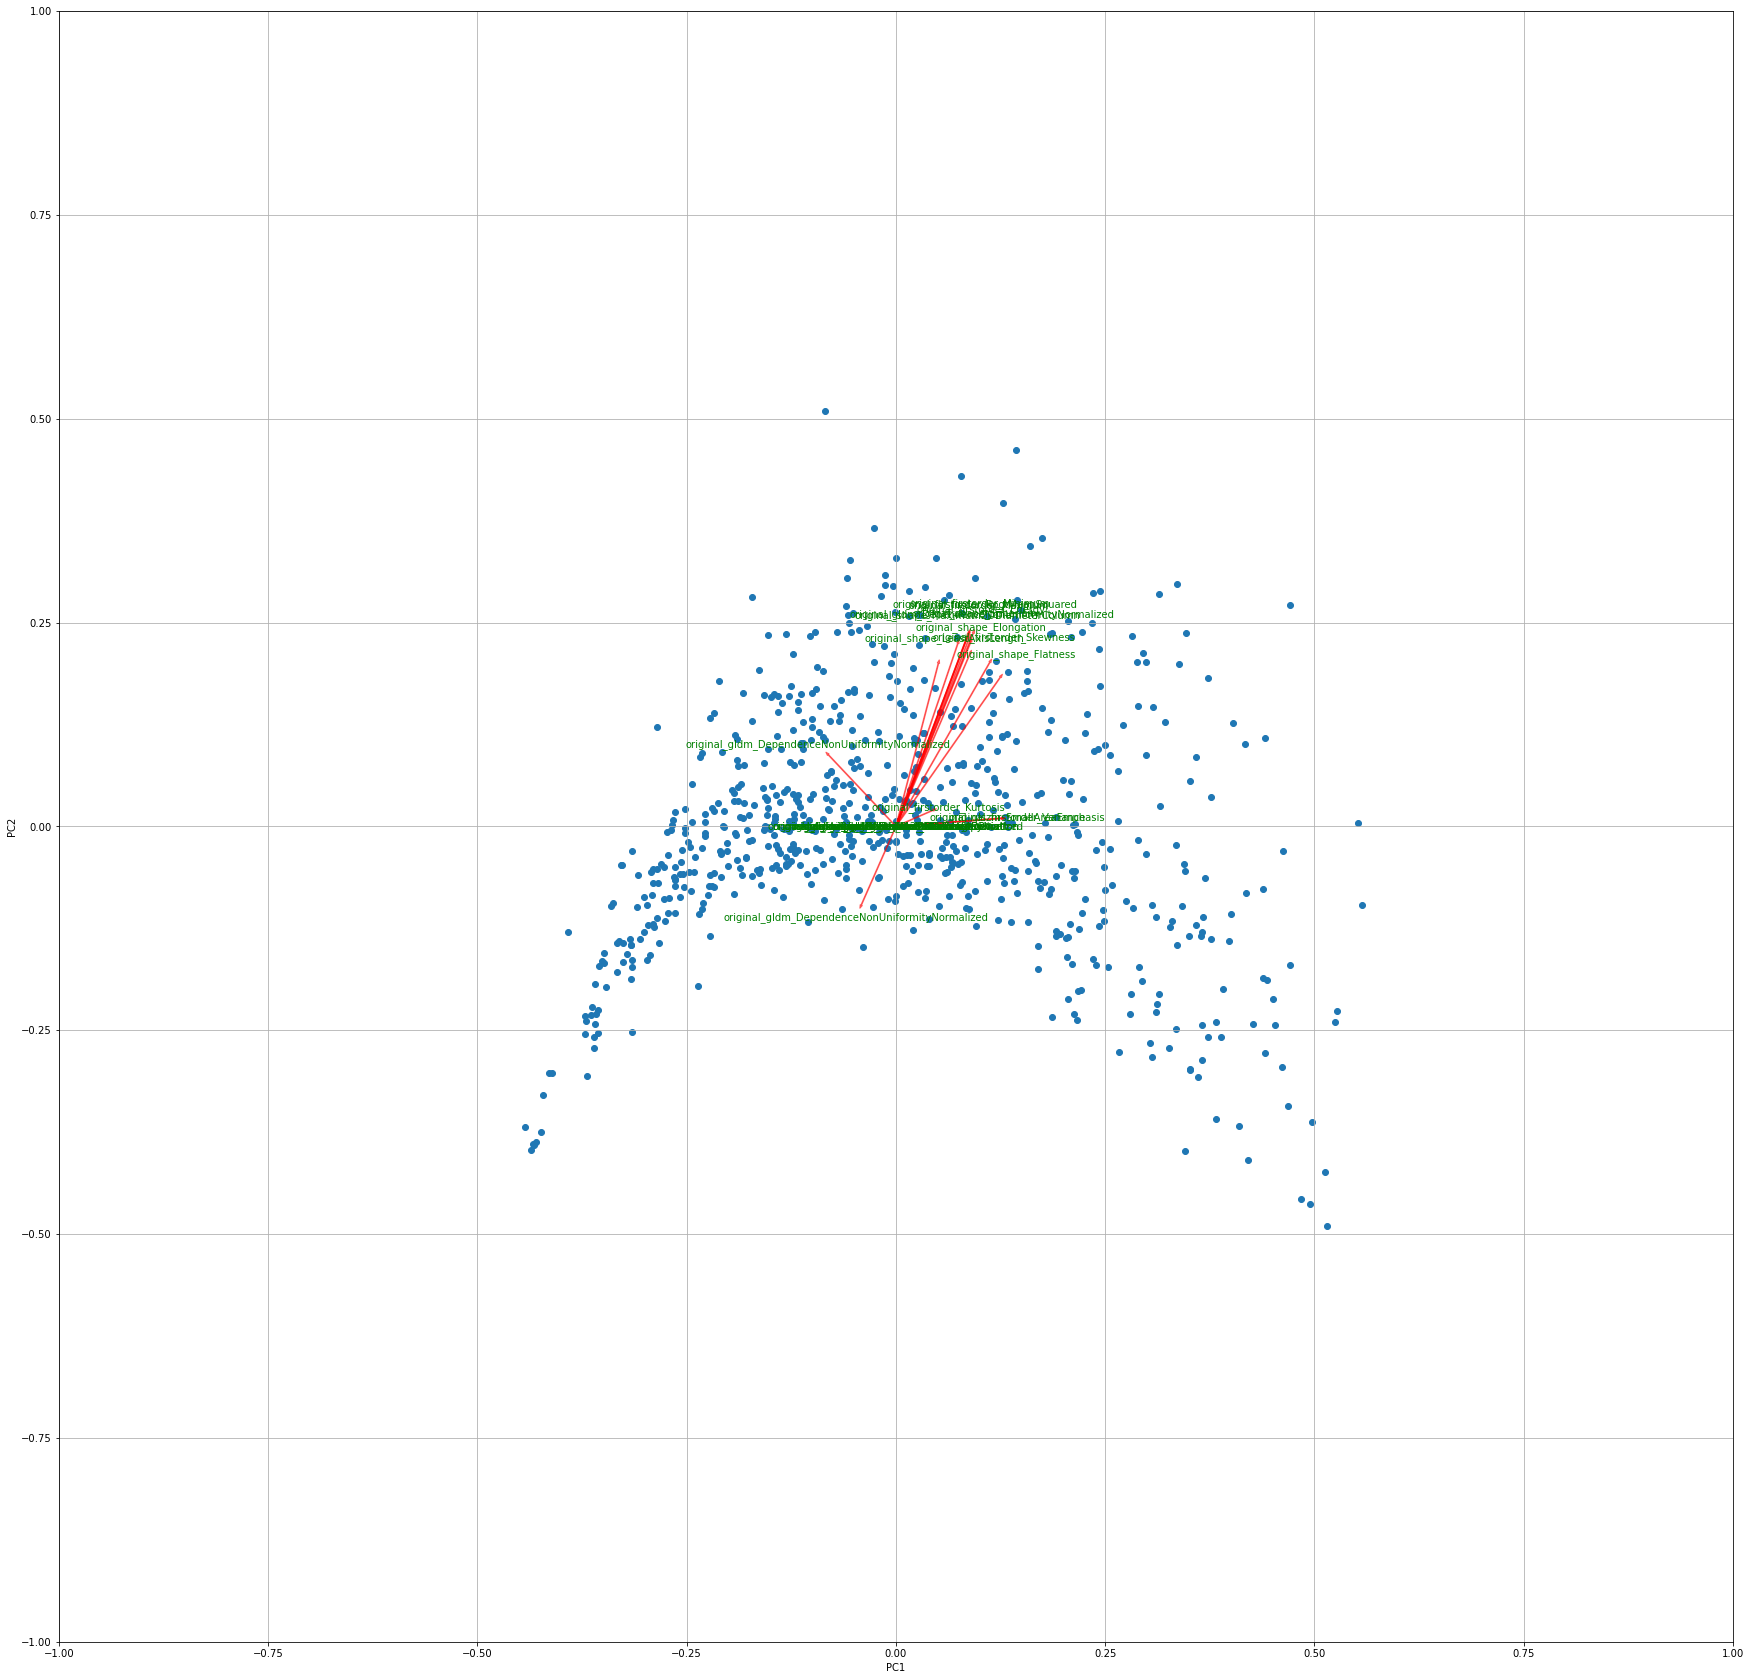

In [14]:
plt.figure(figsize=(30,30))
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
g = df.most_important_feature.tolist()
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2,0:NUMBER_OF_COMPONENTS]),labels=g)
plt.show()

In [15]:
features_selection = cumulative_projections_df.sort_values(by=['cumulative_projection'],ascending=False).iloc[:NUMBER_OF_COMPONENTS].index.tolist()
print(features_selection)

['original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_10Percentile', 'original_firstorder_InterquartileRange', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_firstorder_Variance', 'original_gldm_DependenceNonUniformityNormalized', 'original_shape_Flatness', 'original_shape_Sphericity', 'original_firstorder_Skewness', 'original_shape_Elongation', 'original_shape_Maximum2DDiameterSlice', 'original_firstorder_Minimum', 'original_gldm_DependenceEntropy', 'original_gldm_DependenceNonUniformity', 'original_gldm_DependenceVariance', 'original_firstorder_Median', 'original_firstorder_Kurtosis', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_MinorAxisLength', 'original_firstorder_MeanAbsoluteDeviation', 'original_glrlm_RunVariance', 'original_firstorder_Range', 'original_firstorder_Maximum', 'original_shape_MajorAxisLength', 'original_glszm_ZonePercentage', 'original_shape_LeastAxisLength', 'original_gldm_SmallDe

# Recompute samples

In [16]:
# A list of the valid features, sorted
feature_names = features_selection

In [17]:
N = features.shape[0]

In [18]:
# Make a numpy array of all the values
import numpy as np

samples = np.zeros((N,len(feature_names)))
for case_id in range(N):
    a = np.array([])
    for feature_name in feature_names:
        value = features.iloc[case_id][feature_name]
        if isinstance(value, str) and 'j' in value:
            value = np.abs(np.complex(value))
        a = np.append(a, value)
    samples[case_id-1,:] = a
    
# May have NaNs
samples = np.nan_to_num(samples)

# Multidimensional scaling

[Multidimensional scaling or MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling) is as way to visualize very high dimensional data in a lower dimensional space.  In our case, the feature space is `len(feature_names)` (or 93) dimensional space.  To help us understand the data, we project into 2d space.  MDS preserves the relative distance between sample points during the projection, so two samples close together in 2d space would also be close together in the original 93-dimensional space (and *vice versa*).

We us non-metric algorithm, because our data are highly non uniform in the scale of each feature.

In [19]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=10,
                   dissimilarity="precomputed", n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Plot feature distribution/range projection

Here we use the results.  **NB:** there are two points in the "green-ish" colored circle in the center of the plot.

The feature distribution and range is projected on the disimilarity manifold. The range of values are encoded from lower values to high values in three equiparable ranges. The distibution of values are encoded according to their percentiles in the percentile distributions. 

In [20]:
TARGET_FEATURE = 'original_firstorder_RobustMeanAbsoluteDeviation'
MODE='distibution'

In [21]:
def get_label_positions(features, feature_name, mode='range'):
    
    print('range based labeling')
    values = features[feature_name].to_list()
    def to_num(v):
        return np.abs(np.complex(value)) if isinstance(v, str) and 'j' in v else float(v)
    values = np.array([to_num(v) for v in values])
    if mode == 'range':
        p0 = values.min()
        p1 = (values.max()-values.min())*0.25 + values.min()
        p2 = (values.max()-values.min())*0.50 + values.min()
        p3 = (values.max()-values.min())*0.75 + values.min()
        p4 = values.max()
    elif mode == 'distibution':
        print('distribution based labeling')
        stats = pd.Series(values).describe()
        p0 = stats['min']
        p1 = stats['25%']
        p2 = stats['50%']
        p3 = stats['75%']
        p4 = stats['max']
    else:
        raise Exception('Mode ' + str(mode) + 'not recognized')
    pos1 = [i for i, v in enumerate(values) if v<=p1]
    pos2 = [i for i, v in enumerate(values) if p1<v and v<=p2]
    pos3 = [i for i, v in enumerate(values) if p2<v and v<=p3]
    pos4 = [i for i, v in enumerate(values) if p3<v and v <= p4]
    return pos1, pos2, pos3, pos4

range based labeling
distribution based labeling


C:\Users\Rebecca\Anaconda3\envs\radio\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


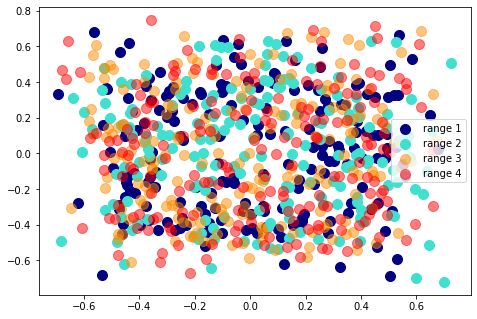

In [22]:
# Plot
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor base on range or distibution
pos1, pos2, pos3, pos4 = get_label_positions(features, TARGET_FEATURE, mode=MODE)

plt.scatter(pos[pos1, 0], pos[pos1, 1], color='navy', alpha=1.0, s=s, lw=1, label='range 1')
plt.scatter(pos[pos2, 0], pos[pos2, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='range 2')
plt.scatter(pos[pos3, 0], pos[pos3, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='range 3')
plt.scatter(pos[pos4, 0], pos[pos4, 1], color='red', alpha=0.5, s=s, lw=1, label='range 4')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

# Plot features as a heatmap

A heat map gives the correlation of features to each other, red indicating positive correlation, and blue negative.  A heatmap may be clustered to show groupings of features that are similar.

<AxesSubplot:>

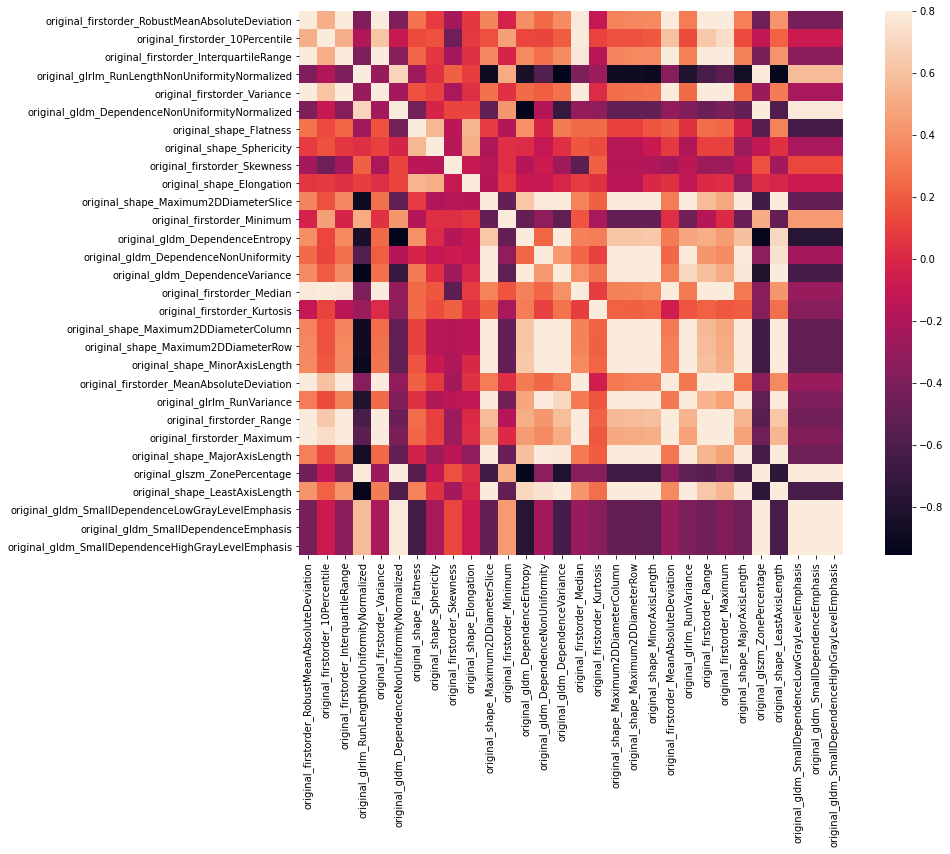

In [23]:
import pandas as pd
import seaborn as sns

# type of each tumor
types = list(range(features.shape[0]))
for i in pos1:
    types[i] = 'range 1' 
for i in pos2:
    types[i] = 'range 2' 
for i in pos3:
    types[i] = 'range 3' 
for i in pos4:
    types[i] = 'range 4' 

    
# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names, index=types)

corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)

# Cluster the heatmap

Though useful, heatmaps tell a much better story if the features are clustered.  Here we take a smaller subset of the features and cluster.  In the [dendrogram](https://en.wikipedia.org/wiki/Dendrogram), there are 2 major groups, and many smaller groupings based on features. 

In [24]:
# Choose a subset of features for clustering
dd = d.iloc[:,1:50]

#sns.clustermap(d, linewidths=.5, figsize=(13,13))
m = dd.to_numpy()

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(m,'ward')

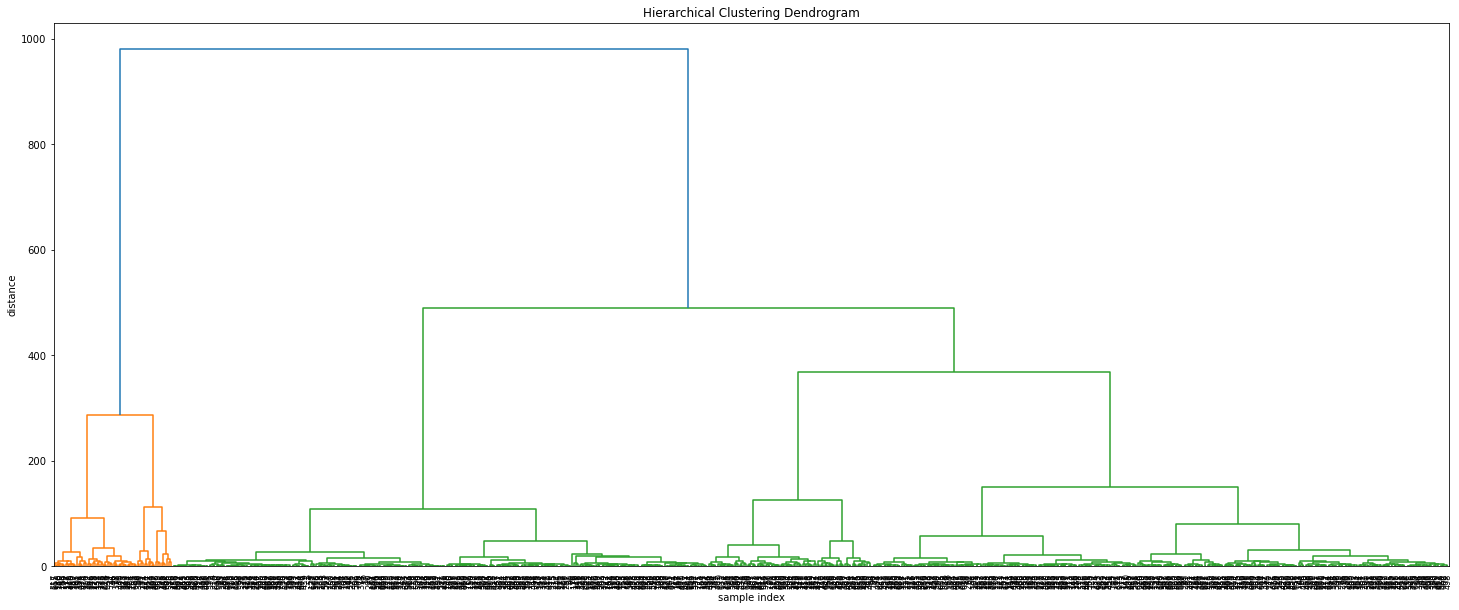

In [25]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [26]:
d.head()

,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_10Percentile,original_firstorder_InterquartileRange,original_glrlm_RunLengthNonUniformityNormalized,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_shape_Flatness,original_shape_Sphericity,original_firstorder_Skewness,original_shape_Elongation,...,original_firstorder_MeanAbsoluteDeviation,original_glrlm_RunVariance,original_firstorder_Range,original_firstorder_Maximum,original_shape_MajorAxisLength,original_glszm_ZonePercentage,original_shape_LeastAxisLength,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis
range 4,0.210236,0.208834,0.494862,0.294088,0.095920,0.066939,0.678978,0.819467,0.183093,0.878564,...,0.265866,1.043450,1.125779,1.190977,5.675400,0.014286,3.853472,0.005741,0.005741,0.005741
range 4,0.097730,0.251392,0.198380,0.334954,0.029939,0.094911,0.936444,0.910142,-0.770906,0.959108,...,0.140406,0.934747,0.676703,0.780028,4.626799,0.015385,4.332737,0.004847,0.004847,0.004847
range 3,0.098363,0.151645,0.274546,0.604615,0.019884,0.388889,0.639602,0.905038,0.275526,0.738549,...,0.127089,0.248974,0.417565,0.516624,3.126944,0.083333,2.000000,0.012303,0.012303,0.012303
range 3,0.032062,0.173624,0.061433,0.719519,0.006137,1.000000,1.000000,0.947814,-1.047974,1.000000,...,0.057516,0.140241,0.267757,0.350712,2.000000,0.125000,2.000000,0.015625,0.015625,0.015625
range 1,0.047867,0.082259,0.083391,0.586644,0.008662,0.289256,0.938083,0.879164,1.073752,0.938083,...,0.071274,0.300870,0.327906,0.388926,2.571297,0.090909,2.412091,0.014357,0.014357,0.014357


C:\Users\Rebecca\Anaconda3\envs\radio\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


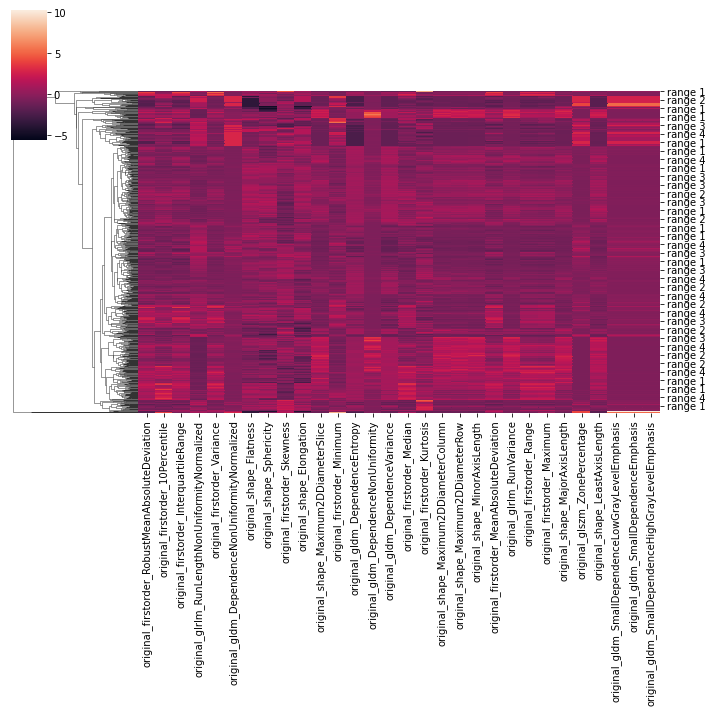

In [27]:
pp = sns.clustermap(d, col_cluster=False, metric='chebyshev', z_score=1)
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

# Generate cluster labels
The cluster are visualized on the PCA projection

In [28]:
from scipy.cluster.hierarchy import fcluster

In [29]:
# based on max distance between clusters
max_d = 50
labels = fcluster(Z, max_d, criterion='distance')
# based on a fixed number of clusters
# k=2
# labels = fcluster(Z, k, criterion='maxclust')
# based on inconsistency
# inconsistency_threshold = 10
# labels = fcluster(Z, inconsistency_threshold, depth=10)

<AxesSubplot:xlabel='x', ylabel='y'>

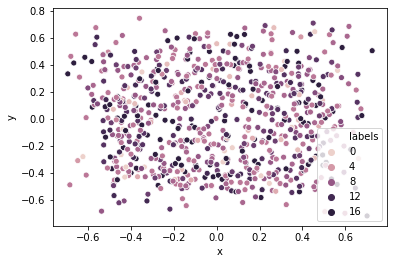

In [30]:
data = pd.DataFrame(data=pos,columns=['x','y'])
data['labels']=labels
sns.scatterplot(x="x", y="y", hue="labels", data=data)

In [82]:
data_tr = pd.DataFrame(data=samples,columns=feature_names)
data_tr['labels']=labels
data_tr.groupby('labels').mean()

,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_10Percentile,original_firstorder_InterquartileRange,original_glrlm_RunLengthNonUniformityNormalized,original_firstorder_Variance,original_gldm_DependenceNonUniformityNormalized,original_shape_Flatness,original_shape_Sphericity,original_firstorder_Skewness,original_shape_Elongation,...,original_firstorder_MeanAbsoluteDeviation,original_glrlm_RunVariance,original_firstorder_Range,original_firstorder_Maximum,original_shape_MajorAxisLength,original_glszm_ZonePercentage,original_shape_LeastAxisLength,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis
labels,,,,,,,,,,,,,,,,,,,,,
1,0.110470,0.204103,0.267943,0.158144,0.034751,0.134141,0.610316,0.840872,-0.045328,0.793317,...,0.148928,4.374282,0.886259,0.940471,13.125131,0.001426,7.813934,0.002689,0.002689,0.002689
2,0.119905,0.225035,0.292613,0.162803,0.041369,0.120941,0.604325,0.834474,0.026413,0.744315,...,0.162430,4.209623,0.943107,1.003743,12.951059,0.001626,7.622978,0.002785,0.002785,0.002785
3,0.108429,0.178156,0.263687,0.149195,0.033377,0.149255,0.617902,0.843456,0.180765,0.743616,...,0.146075,5.077923,0.856252,0.913150,13.817322,0.001237,8.441164,0.002612,0.002612,0.002612
4,0.091972,0.160360,0.224248,0.134008,0.024078,0.177159,0.663095,0.858843,0.311633,0.749868,...,0.126273,5.697653,0.825766,0.881689,14.383999,0.000984,9.496979,0.002471,0.002471,0.002471
5,0.129210,0.226898,0.316765,0.140036,0.045127,0.158352,0.632124,0.842992,0.054898,0.748985,...,0.173348,5.690318,1.074316,1.132797,14.241206,0.001084,8.907852,0.002591,0.002591,0.002591
6,0.057199,0.176863,0.143450,0.609995,0.015102,0.662245,0.517429,0.848633,0.136301,0.806027,...,0.091843,0.233806,0.314186,0.461830,2.641087,0.167933,1.351569,0.038806,0.038806,0.038806
7,0.087561,0.175678,0.207541,0.477886,0.023753,0.160743,0.676352,0.865273,0.192019,0.796241,...,0.119995,0.423412,0.511784,0.624385,3.927860,0.049097,2.557481,0.009743,0.009743,0.009743
8,0.111648,0.228728,0.270175,0.191929,0.038624,0.089586,0.660486,0.844424,-0.117353,0.778611,...,0.153305,2.916610,0.873839,0.943240,10.246069,0.002827,6.586529,0.003190,0.003190,0.003190
9,0.109185,0.241658,0.264387,0.178828,0.036452,0.110144,0.662807,0.862561,-0.193990,0.760611,...,0.150117,3.351041,0.897175,0.964274,11.171772,0.002149,7.238223,0.002912,0.002912,0.002912


# TSNE the projection 

In [31]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array(samples)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(757, 2)

<AxesSubplot:xlabel='x', ylabel='y'>

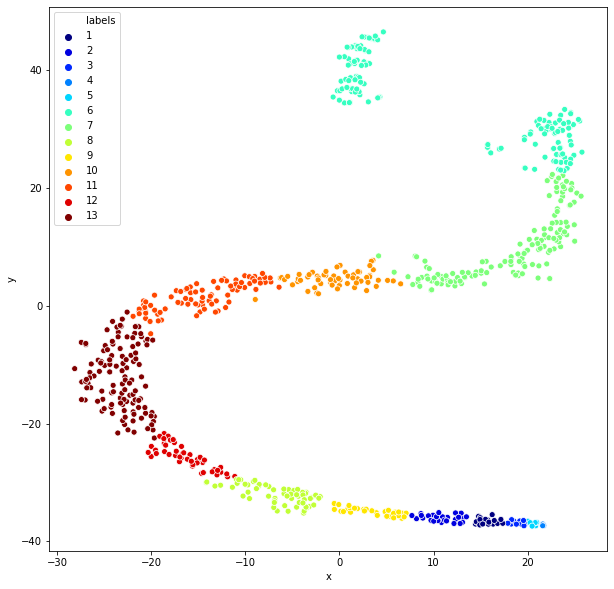

In [68]:
data = pd.DataFrame(data=X_embedded,columns=['x','y'])
data['labels']=labels
plt.figure(figsize=(10,10))
sns.scatterplot(x="x", y="y", hue="labels", data=data, palette='jet',legend='full')

# Visualize cluster samples

Visualization of samples

In [33]:
import ipyvolume as ipv
from tiffile import imread
import random

In [34]:
cluster_pos = []
for c in np.unique(labels):
    cluster_pos.append((labels==c).nonzero()[0].tolist())

In [35]:
def open_3d_vol(index):
    Vol = imread(features.Image[index])
    Mask = imread(features.Mask[index])
    Vol = (Vol-Vol.min())/(Vol.max()-Vol.min())
    Vol = np.where(Mask==features.Label[index],Vol,0)
    Bg = np.where(Mask==features.Label[index],0,Vol)
    Mask = np.where(Mask==features.Label[index],0.5,0)

    x,y,z,dx,dy,dz = eval(features['diagnostics_Mask-original_BoundingBox'][index])
    
    minz = z-10 if z-10>0 else 0
    miny = y-10 if y-10>0 else 0
    minx = x-10 if x-10>0 else 0
    maxz = z+dz+10 if z+dz+10<Vol.shape[0] else Vol.shape[0]
    maxy = y+dy+10 if y+dy+10<Vol.shape[1] else Vol.shape[1]
    maxx = x+dx+10 if x+dx+10<Vol.shape[2] else Vol.shape[2]
    
    Vol = Vol[minz:maxz,miny:maxy,minx:maxx]
    Mask = Mask[minz:maxz,miny:maxy,minx:maxx]
    Bg = Bg[minz:maxz,miny:maxy,minx:maxx]
    return Vol, Mask, Bg
    


In [84]:
# PLOT Cluster
#////////////////
CLUSTER = 13
#/////////////

p= random.choice(cluster_pos[CLUSTER-1])
title = f'cell id: {features.Label[p]} at CLUSTER {CLUSTER}'
print('========================================')
print('========================================')
print('              ', title,'')
print('features:')
print('', data_tr.iloc[p])
print('========================================')
print('========================================')
Vol, Mask, Bg = open_3d_vol(p)
ipv.figure()
ipv.volshow(Vol, level=[.15,0.0,0.0], opacity=[1,0,0], level_width=0.1, data_min=0, data_max=1)
# ipv.volshow(Bg, level=[0.0,0.25,0.0], opacity=[0,1,0], level_width=0.1, data_min=0, data_max=1)
# ipv.volshow(Mask, level=[0.0,0.0,0.5], opacity=[0,0,1.0], level_width=0.25, data_min=0, data_max=1)

ipv.view(-30, 40)
ipv.show()

               cell id: 6644 at CLUSTER 13 
features:
 original_firstorder_RobustMeanAbsoluteDeviation        0.082963
original_firstorder_10Percentile                       0.127096
original_firstorder_InterquartileRange                 0.197778
original_glrlm_RunLengthNonUniformityNormalized        0.237466
original_firstorder_Variance                           0.016219
original_gldm_DependenceNonUniformityNormalized        0.060309
original_shape_Flatness                                0.551874
original_shape_Sphericity                              0.824744
original_firstorder_Skewness                           0.297716
original_shape_Elongation                              0.745659
original_shape_Maximum2DDiameterSlice                  9.486833
original_firstorder_Minimum                            0.064721
original_gldm_DependenceEntropy                        4.158217
original_gldm_DependenceNonUniformity                 10.855556
original_gldm_DependenceVariance                 

In [83]:
# PLOT Cluster
#////////////////
CLUSTER = 6
#/////////////

p= random.choice(cluster_pos[CLUSTER-1])
title = f'cell id: {features.Label[p]} at CLUSTER {CLUSTER}'
print('========================================')
print('========================================')
print('              ', title,'')
print('features:')
print('', data_tr.iloc[p])
print('========================================')
print('========================================')
Vol, Mask, Bg = open_3d_vol(p)
ipv.figure()
ipv.volshow(Vol, level=[.15,0.0,0.0], opacity=[1,0,0], level_width=0.1, data_min=0, data_max=1)
# ipv.volshow(Bg, level=[0.0,0.25,0.0], opacity=[0,1,0], level_width=0.1, data_min=0, data_max=1)
# ipv.volshow(Mask, level=[0.0,0.0,0.5], opacity=[0,0,1.0], level_width=0.25, data_min=0, data_max=1)

ipv.view(-30, 40)
ipv.show()

               cell id: 6676 at CLUSTER 6 
features:
 original_firstorder_RobustMeanAbsoluteDeviation       0.038820
original_firstorder_10Percentile                      0.098194
original_firstorder_InterquartileRange                0.082873
original_glrlm_RunLengthNonUniformityNormalized       0.539358
original_firstorder_Variance                          0.013867
original_gldm_DependenceNonUniformityNormalized       0.239669
original_shape_Flatness                               0.751553
original_shape_Sphericity                             0.855193
original_firstorder_Skewness                          1.937026
original_shape_Elongation                             0.911825
original_shape_Maximum2DDiameterSlice                 3.162278
original_firstorder_Minimum                           0.062901
original_gldm_DependenceEntropy                       2.186704
original_gldm_DependenceNonUniformity                 2.636364
original_gldm_DependenceVariance                      1.504132
o

C:\Users\Rebecca\Anaconda3\envs\radio\lib\site-packages\ipyvolume\serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)
